In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from deluca.envs import Reacher
from deluca.agents import ILQR
from deluca.agents import ILC
from deluca.agents import IGPC
from deluca.agents._ilqr import rollout
import numpy as np

/home/alexjyu/miniconda3/envs/ealstm/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/alexjyu/miniconda3/envs/ealstm/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
global_log = []
ALPHA = 1.0
LR = 0.01

In [5]:
env_true, env_sim = Reacher(-10.), Reacher()
print('-------------- ilqr_sim ----------------')
ilqr_sim = ILQR()
ilqr_sim.train(env_sim, 5, alpha=ALPHA)
print('----------- compute zero_cost -----------')
env_ZEROCOST = Reacher(-10.)
_,_,ZEROCOST = rollout(env_ZEROCOST, ilqr_sim.U, ilqr_sim.k, ilqr_sim.K, ilqr_sim.X)
print('ZEROCOST:' + str(ZEROCOST))
global_log += ['ZEROCOST: ' + str(ZEROCOST)]
print('-------------- ilqr_true ----------------')
ilqr_true = ILQR()
c, log = ilqr_true.train(env_true, 10, ilqr_sim.U, alpha=ALPHA)
global_log += log

-------------- ilqr_sim ----------------
initial cost:29.766178
(iLQR): t = 0, r = 2, c = 11.271796226501465, alpha = 1.100000023841858
(iLQR): t = 1, r = 3, c = 11.118474960327148, alpha = 1.2100000381469727
(iLQR): t = 2, r = 4, c = 11.112727165222168, alpha = 1.3310000896453857
(iLQR): t = 3, r = 6, c = 11.112680435180664, alpha = 1.3310000896453857
(iLQR): t = 4, r = 7, c = 11.112521171569824, alpha = 1.4641001224517822
----------- compute zero_cost -----------
ZEROCOST:2413.7056
-------------- ilqr_true ----------------
initial cost:1055.0634
(iLQR): t = 0, r = 2, c = 941.4541015625, alpha = 1.100000023841858
(iLQR): t = 1, r = 3, c = 935.1439208984375, alpha = 1.2100000381469727
(iLQR): t = 2, r = 4, c = 924.70703125, alpha = 1.3310000896453857
(iLQR): t = 3, r = 5, c = 881.9180297851562, alpha = 1.4641001224517822
(iLQR): t = 4, r = 9, c = 839.0318603515625, alpha = 0.683013379573822
(iLQR): t = 5, r = 10, c = 820.6473388671875, alpha = 0.7513146996498108
(iLQR): t = 6, r = 11, 

In [145]:
### Hyperparameter Search - ILC Alpha
ilc = ILC()
U = ilqr_sim.U
c_min = 1000000000
good_alpha = 1.0
# for alpha in [0.1,0.2,0.5, 0.8, 1.0, 2.0, 5.0, 10.0]:
for alpha in [ALPHA]:
    print(f"Trying alpha {alpha}")
    c, log = ilc.train(env_true, env_sim, 40, U, ilqr_sim.k, ilqr_sim.K, ilqr_sim.X, ref_alpha=alpha)
    if alpha == ALPHA: # best alpha
        global_log += log
    if c < c_min:
        c_min = c
        good_alpha = alpha
        print(f"Better Min Changing alpha to {good_alpha}")
env_true.close(), env_sim.close()

Trying alpha 1.0
initial cost:2413.70623260845
(iLC): t = 0, r = 2, c = 2191.6511204480767, alpha = 1.1
(iLC): t = 1, r = 3, c = 1824.671659369263, alpha = 1.2100000000000002
(iLC): t = 2, r = 4, c = 1619.4398374479622, alpha = 1.3310000000000004
(iLC): t = 3, r = 7, c = 1340.7737375969202, alpha = 1.0000000000000002
(iLC): t = 4, r = 10, c = 1319.1527306105083, alpha = 0.7513148009015778
(iLC): t = 5, r = 11, c = 999.867282751434, alpha = 0.8264462809917356
(iLC): t = 6, r = 12, c = 818.2600718883663, alpha = 0.9090909090909092
(iLC): t = 7, r = 13, c = 798.2433442330674, alpha = 1.0000000000000002
(iLC): t = 8, r = 14, c = 782.9633567040827, alpha = 1.1000000000000003
(iLC): t = 9, r = 16, c = 782.8086837211823, alpha = 1.1000000000000003
Better Min Changing alpha to 1.0


(None, None)

In [146]:
### Hyperparameter Search - IGPC Alpha
igpc = IGPC()
U = ilqr_sim.U
c_min = 1000000000
good_alpha = 100000
good_lr = 10000
# for alpha in [0.5, 1.0]:
#     for lr in [0.001, 0.005, 0.01, 0.05, 0.1]:
for alpha in [ALPHA]:
    for lr in [LR]:
        print(f"Trying pair {alpha},{lr}")
        c, log = igpc.train(env_true, env_sim, 10, U, ilqr_sim.k, ilqr_sim.K, ilqr_sim.X, lr=lr, ref_alpha=alpha)
        # _,_,_,_,c = Eastman_closed(env_true, env_sim, U, 10, k, K, X, lr=lr, ref_alpha=alpha)
        if alpha == ALPHA and lr == LR: # best alpha/lr
            global_log += log
        if c < c_min:
            c_min = c
            good_alpha = alpha
            good_lr = lr
            print(f"Better Min Changing alpha,lr to {good_alpha},{lr}")

Trying pair 1.0,0.01
initial cost:2413.70623260845
(iGPC): t = 0, r = 2, c = 2176.3359356742485, alpha = 1.1
(iGPC): t = 1, r = 3, c = 1807.9058026603147, alpha = 1.2100000000000002
(iGPC): t = 2, r = 4, c = 1634.2014258440536, alpha = 1.3310000000000004
(iGPC): t = 3, r = 7, c = 1375.2480436160788, alpha = 1.0000000000000002
(iGPC): t = 4, r = 10, c = 1305.6446123644546, alpha = 0.7513148009015778
(iGPC): t = 5, r = 11, c = 986.3836548529083, alpha = 0.8264462809917356
(iGPC): t = 6, r = 12, c = 821.4397017982159, alpha = 0.9090909090909092
(iGPC): t = 7, r = 13, c = 793.9354347824788, alpha = 1.0000000000000002
(iGPC): t = 8, r = 14, c = 785.1695359810136, alpha = 1.1000000000000003
(iGPC): t = 9, r = 15, c = 780.1971874723374, alpha = 1.2100000000000004
Better Min Changing alpha,lr to 1.0,0.01


{-10.0: {'(iLQR)': [[0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 11.0, 12.0, 13.0, 14.0], [2410.147279547979, 983.0906436909004, 938.5344542156969, 932.8873268569384, 925.0480323507606, 907.4524148835704, 837.8500853600798, 803.0318905257647, 784.5997752461521, 765.4000591371008, 754.8495975637347]], '(iLC)': [[0, 2.0, 3.0, 4.0, 5.0, 8.0, 9.0, 10.0, 11.0, 12.0, 16.0], [2410.147279547979, 1801.8805080969594, 1561.657556499191, 1382.917217094581, 1093.3233645343757, 993.1434786880517, 837.0108850110917, 803.6066405373315, 788.4636357077951, 783.1430610335348, 783.0918982693078]], '(iGPC)': [[0, 2.0, 3.0, 4.0, 5.0, 8.0, 9.0, 10.0, 11.0, 12.0], [2410.147279547979, 1799.8862479255968, 1551.5492099108567, 1377.967631442432, 1056.8558155255803, 968.7563930504405, 831.8942700748361, 802.0686393920271, 787.6470115005179, 783.2752362255071]]}}


<Figure size 432x288 with 0 Axes>

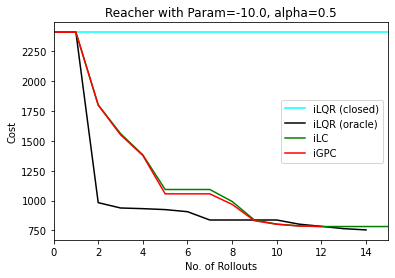

In [142]:
# Plot alpha = 0.5 experiment

import matplotlib.pyplot as plt
from pprint import pprint
import re
import sys

global_log_alpha_half = ''
for s in global_log:
    global_log_alpha_half += s + '\n'
print(global_log_alpha_half)

def postprocess(a):
    rs, vs = a
    newrs, newvs = [], []
    ref = 0
    for (i, (r, v)) in enumerate(zip(rs, vs)):
        r = int(r)
        if i == len(rs) - 1:
            newrs += [r]
            newvs += [v]
        else:
            next_r = int(rs[i + 1])
            newrs += list(range(r, next_r))
            newvs += [v for _ in range(r, next_r)]
    return newrs, newvs


### This file is to plot the results of the first experiment on Quadrotor

all_results = {}
for param in [-10.0]:
    # filename = f"../results/reacher_results/param_{param}_alpha_0.5.txt"
    # txt = open(filename).read()
    txt = global_log_alpha_half
    pattern = f"ZEROCOST: ([0-9.]*)"
    results = re.findall(pattern, txt)
    zerocost = float(results[0])

    pattern = f"(.*): t = [0-9]*, r = ([0-9]*), c = ([0-9.]*)"
    results = list(zip(*re.findall(pattern, txt)))
    if len(results) > 0:
        results = results[0], list(map(float, results[1])), list(map(float, results[2]))
    all_keys = list(set(results[0]))
    
    results_dict = {}
    for k in all_keys:
        indices = [i for i, x in enumerate(results[0]) if x == k]
        results_dict[k] = [
            [0] + [results[1][i] for i in indices],
            [zerocost] + [results[2][i] for i in indices],
        ]
    all_results[param] = results_dict

print(all_results)

#print(postprocess(all_results[-10.0]['Eastman (closed+de+lr+0.01)']))
plt.figure()
fig, ax = plt.subplots(1, 1)
x_dict = {-10.0: 15}
for (i, w) in enumerate([-10.0]):
    a = ax
    px, py = list(range(0, 100)), [
        all_results[w]["(iLQR)"][1][0] for _ in range(0, 100)
    ]
    a.plot(px, py, label="iLQR (closed)", color="aqua")
    px, py = postprocess(all_results[w]["(iLQR)"])
    a.plot(px, py, label="iLQR (oracle)", color="black")
    px, py = postprocess(all_results[w]["(iLC)"])
    a.plot(px, py, label="iLC", color="green")
    px, py = postprocess(all_results[w]["(iGPC)"])
    a.plot(px, py, label="iGPC", color="red")
    # a.set_ylim(0, 5000)
    a.set_xlim(0, x_dict[w])
    a.set_xlabel("No. of Rollouts")
    a.set_ylabel("Cost")
    a.set_title(f"Reacher with Param={w}, alpha=0.5")
    # #plt.yscale('log')
    a.legend(loc="best")
plt.show()


ZEROCOST: 2413.70623260845
(iLQR): t = 0, r = 2, c = 941.4542109231629, alpha = 1.1
(iLQR): t = 1, r = 3, c = 935.1437689387272, alpha = 1.2100000000000002
(iLQR): t = 2, r = 4, c = 924.7075508102951, alpha = 1.3310000000000004
(iLQR): t = 3, r = 5, c = 881.9217489458857, alpha = 1.4641000000000006
(iLQR): t = 4, r = 9, c = 839.0378681106843, alpha = 0.6830134553650705
(iLQR): t = 5, r = 10, c = 820.6431560880089, alpha = 0.7513148009015777
(iLQR): t = 6, r = 11, c = 811.5600705687381, alpha = 0.8264462809917354
(iLQR): t = 7, r = 14, c = 791.9422730630035, alpha = 0.620921323059155
(iLQR): t = 8, r = 15, c = 773.8183249585162, alpha = 0.6830134553650706
(iLQR): t = 9, r = 16, c = 761.481994694511, alpha = 0.7513148009015778
(iLC): t = 0, r = 2, c = 2191.6511204480767, alpha = 1.1
(iLC): t = 1, r = 3, c = 1824.671659369263, alpha = 1.2100000000000002
(iLC): t = 2, r = 4, c = 1619.4398374479622, alpha = 1.3310000000000004
(iLC): t = 3, r = 7, c = 1340.7737375969202, alpha = 1.0000000000

<Figure size 432x288 with 0 Axes>

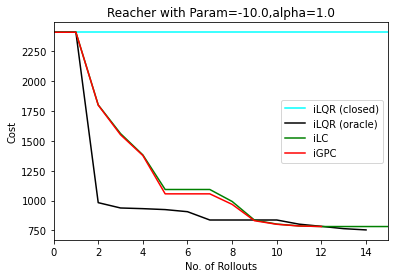

In [147]:
# plot alpha = 1.0 experiment

import matplotlib.pyplot as plt
from pprint import pprint
import re
import sys

global_log_alpha_one = ''
for s in global_log:
    global_log_alpha_one += s + '\n'
print(global_log_alpha_one)

def postprocess(a):
    rs, vs = a
    newrs, newvs = [], []
    ref = 0
    for (i, (r, v)) in enumerate(zip(rs, vs)):
        r = int(r)
        if i == len(rs) - 1:
            newrs += [r]
            newvs += [v]
        else:
            next_r = int(rs[i + 1])
            newrs += list(range(r, next_r))
            newvs += [v for _ in range(r, next_r)]
    return newrs, newvs


### This file is to plot the results of the first experiment on Quadrotor

all_results = {}
for param in [-10.0]:
    # filename = f"../results/reacher_results/param_{param}_alpha_0.5.txt"
    # txt = open(filename).read()
    txt = global_log_alpha_half
    pattern = f"ZEROCOST: ([0-9.]*)"
    results = re.findall(pattern, txt)
    zerocost = float(results[0])

    pattern = f"(.*): t = [0-9]*, r = ([0-9]*), c = ([0-9.]*)"
    results = list(zip(*re.findall(pattern, txt)))
    if len(results) > 0:
        results = results[0], list(map(float, results[1])), list(map(float, results[2]))
    all_keys = list(set(results[0]))
    
    results_dict = {}
    for k in all_keys:
        indices = [i for i, x in enumerate(results[0]) if x == k]
        results_dict[k] = [
            [0] + [results[1][i] for i in indices],
            [zerocost] + [results[2][i] for i in indices],
        ]
    all_results[param] = results_dict

print(all_results)

#print(postprocess(all_results[-10.0]['Eastman (closed+de+lr+0.01)']))
plt.figure()
fig, ax = plt.subplots(1, 1)
x_dict = {-10.0: 15}
for (i, w) in enumerate([-10.0]):
    a = ax
    px, py = list(range(0, 100)), [
        all_results[w]["(iLQR)"][1][0] for _ in range(0, 100)
    ]
    a.plot(px, py, label="iLQR (closed)", color="aqua")
    px, py = postprocess(all_results[w]["(iLQR)"])
    a.plot(px, py, label="iLQR (oracle)", color="black")
    px, py = postprocess(all_results[w]["(iLC)"])
    a.plot(px, py, label="iLC", color="green")
    px, py = postprocess(all_results[w]["(iGPC)"])
    a.plot(px, py, label="iGPC", color="red")
    # a.set_ylim(0, 5000)
    a.set_xlim(0, x_dict[w])
    a.set_xlabel("No. of Rollouts")
    a.set_ylabel("Cost")
    a.set_title(f"Reacher with Param={w},alpha=1.0")
    # #plt.yscale('log')
    a.legend(loc="best")
plt.show()


In [ ]:
# Best Choices for ILC/IGPC in wilhelm for reference
'''
Trying alpha 0.5
initial cost 2405.73046875
iLC (closed+alpha=0.5): t = 0, r = 2, c = 1792.3660888671875, alpha = 0.550000011920929
iLC (closed+alpha=0.5): t = 1, r = 3, c = 1553.2510986328125, alpha = 0.6050000190734863
iLC (closed+alpha=0.5): t = 2, r = 4, c = 1380.19482421875, alpha = 0.6655000448226929
iLC (closed+alpha=0.5): t = 3, r = 5, c = 1076.9576416015625, alpha = 0.7320500612258911
iLC (closed+alpha=0.5): t = 4, r = 8, c = 981.8692626953125, alpha = 0.550000011920929
iLC (closed+alpha=0.5): t = 5, r = 9, c = 834.8849487304688, alpha = 0.6050000190734863
iLC (closed+alpha=0.5): t = 6, r = 10, c = 802.7842407226562, alpha = 0.6655000448226929
iLC (closed+alpha=0.5): t = 7, r = 11, c = 787.9957885742188, alpha = 0.7320500612258911
iLC (closed+alpha=0.5): t = 8, r = 12, c = 783.0912475585938, alpha = 0.8052550554275513
iLC (closed+alpha=0.5): t = 9, r = 16, c = 783.0751953125, alpha = 0.3756573498249054
'''
'''
Trying pair 0.5,0.01
initial cost 2405.73046875
Eastman (closed+de+lr+0.01): t = 0, r = 2, c = 1734.281982421875, alpha = 0.550000011920929
Eastman (closed+de+lr+0.01): t = 1, r = 3, c = 1391.4644775390625, alpha = 0.6050000190734863
Eastman (closed+de+lr+0.01): t = 2, r = 6, c = 1212.8800048828125, alpha = 0.4545454680919647
Eastman (closed+de+lr+0.01): t = 3, r = 7, c = 967.5982666015625, alpha = 0.5
Eastman (closed+de+lr+0.01): t = 4, r = 8, c = 862.6428833007812, alpha = 0.550000011920929
Eastman (closed+de+lr+0.01): t = 5, r = 9, c = 822.8616943359375, alpha = 0.6050000190734863
Eastman (closed+de+lr+0.01): t = 6, r = 10, c = 803.0556640625, alpha = 0.6655000448226929
Eastman (closed+de+lr+0.01): t = 7, r = 11, c = 794.2657470703125, alpha = 0.7320500612258911
Eastman (closed+de+lr+0.01): t = 8, r = 12, c = 791.7740478515625, alpha = 0.8052550554275513
'''
'''
Trying alpha 1.0
initial cost 2405.73046875
iLC (closed+alpha=1.0): t = 0, r = 2, c = 2162.005126953125, alpha = 1.100000023841858
iLC (closed+alpha=1.0): t = 1, r = 3, c = 1832.57080078125, alpha = 1.2100000381469727
iLC (closed+alpha=1.0): t = 2, r = 4, c = 1632.4400634765625, alpha = 1.3310000896453857
iLC (closed+alpha=1.0): t = 3, r = 7, c = 1385.662841796875, alpha = 1.0000001192092896
iLC (closed+alpha=1.0): t = 4, r = 10, c = 1301.089599609375, alpha = 0.7513148784637451
iLC (closed+alpha=1.0): t = 5, r = 11, c = 957.1361694335938, alpha = 0.8264463543891907
iLC (closed+alpha=1.0): t = 6, r = 12, c = 850.0101318359375, alpha = 0.9090909957885742
iLC (closed+alpha=1.0): t = 7, r = 13, c = 778.43603515625, alpha = 1.0000001192092896
iLC (closed+alpha=1.0): t = 8, r = 19, c = 778.3656005859375, alpha = 0.10152555257081985
'''
'''
Trying pair 1.0,0.01
initial cost 2405.73046875
Eastman (closed+de+lr+0.01): t = 0, r = 2, c = 2021.6158447265625, alpha = 1.100000023841858
Eastman (closed+de+lr+0.01): t = 1, r = 3, c = 1625.6275634765625, alpha = 1.2100000381469727
Eastman (closed+de+lr+0.01): t = 2, r = 4, c = 1478.7269287109375, alpha = 1.3310000896453857
Eastman (closed+de+lr+0.01): t = 3, r = 5, c = 1426.17626953125, alpha = 1.4641001224517822
Eastman (closed+de+lr+0.01): t = 4, r = 9, c = 1207.699951171875, alpha = 0.683013379573822
Eastman (closed+de+lr+0.01): t = 5, r = 10, c = 790.8485107421875, alpha = 0.7513146996498108
Eastman (closed+de+lr+0.01): t = 6, r = 11, c = 779.9273071289062, alpha = 0.8264461755752563
'''